Converged in 10 iterations (GPU)
Processing time GPu: 16.08 seconds


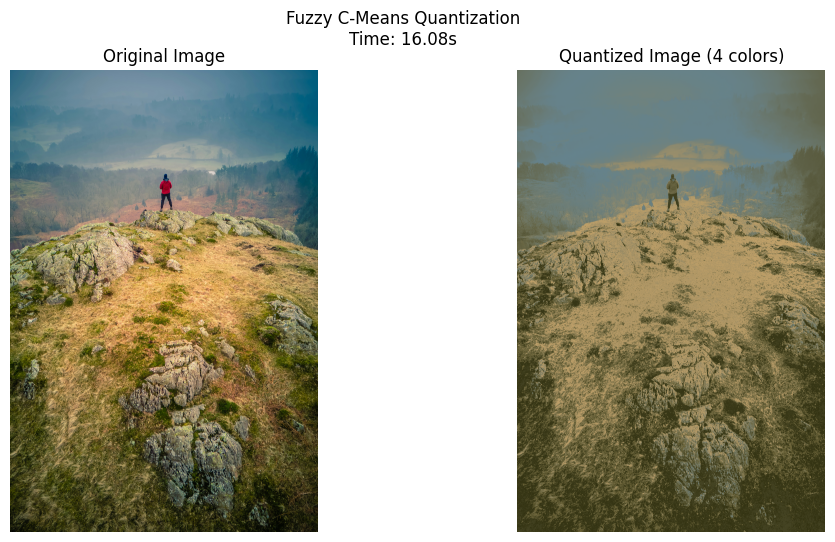

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from fcmeans import FCM  # For CPU-based FCM
from fuzzy_c_means_shared_cuda import OptimizedFuzzyCMeans  # For GPU-based FCM
import time
import multiprocessing


def quantize_image_CMean(image_path, n_clusters=10, m=2.0):
    # Load image and convert to array of pixels
    image = Image.open(image_path)
    N, M = image.size
    X = np.asarray(image).reshape((N * M, 3))

    # Normalize data for cost calculation
    X_normalized = X.astype(np.float32) / 255.0

    start_time = time.time()

    fcm = OptimizedFuzzyCMeans(n_clusters=n_clusters, max_iter=10, m=m)
    fcm.fit(X)
    quantized_X, memberships = fcm.predict(X)
    transformed_X = quantized_X
    print(f"Converged in {fcm.n_iter_} iterations (GPU)")

    elapsed_time = time.time() - start_time
    print(f"Processing time GPu: {elapsed_time:.2f} seconds")

    # Convert the quantized array back to image format
    quantized_array = transformed_X.astype('uint8').reshape((M, N, 3))
    quantized_image = Image.fromarray(quantized_array)

    # Display original and quantized images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(quantized_image)
    ax[1].set_title(f"Quantized Image ({n_clusters} colors)")
    ax[1].axis("off")

    plt.suptitle(
        f"Fuzzy C-Means Quantization\n" +
        f"Time: {elapsed_time:.2f}s", 
        fontsize=12
    )
    
    plt.show()

image_path = 'images/bigimage.jpg'
quantize_image_CMean(image_path, n_clusters=4, m=2.0)

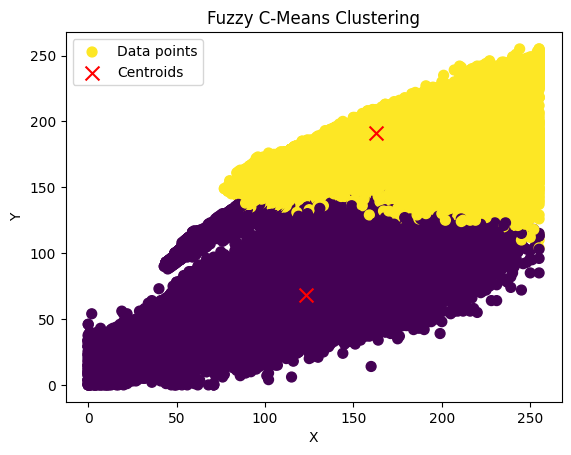

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, float32

# Parameters
MAX_ITER = 100
M = 2.0  # Fuzziness parameter
EPSILON = 1e-5

# CUDA kernel to calculate distances
@cuda.jit
def calculate_distances(data, centroids, distances):
    i = cuda.grid(1)
    if i < data.shape[0]:
        for j in range(centroids.shape[0]):
            dist = 0
            for k in range(data.shape[1]):
                dist += (data[i, k] - centroids[j, k]) ** 2
            distances[i, j] = np.sqrt(dist)

# Update membership matrix
def update_membership(data, centroids, m):
    N = data.shape[0]
    C = centroids.shape[0]
    U = np.zeros((N, C))

    for i in range(N):
        for j in range(C):
            sum_term = 0
            for k in range(C):
                dist_ratio = np.linalg.norm(data[i] - centroids[j]) / np.linalg.norm(data[i] - centroids[k])
                sum_term += dist_ratio ** (2 / (m - 1))
            U[i, j] = 1 / sum_term
    return U

# Update centroids
def update_centroids(data, U, m):
    return (U.T ** m @ data) / (np.sum(U.T ** m, axis=1, keepdims=True))

# Fuzzy C-Means function
def fuzzy_c_means(data, n_clusters, m=M, max_iter=MAX_ITER, epsilon=EPSILON):
    # Initialize centroids and membership matrix randomly
    centroids = data[np.random.choice(data.shape[0], n_clusters, replace=False)]
    U = np.random.rand(data.shape[0], n_clusters)
    U /= np.sum(U, axis=1, keepdims=True)

    for _ in range(max_iter):
        # Update centroids and membership matrix
        new_centroids = update_centroids(data, U, m)
        U = update_membership(data, new_centroids, m)

        # Check convergence
        if np.linalg.norm(new_centroids - centroids) < epsilon:
            break
        centroids = new_centroids

    return centroids, U

# Visualization function
def plot_clusters(data, centroids, U):
    cluster_labels = np.argmax(U, axis=1)
    plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis', marker='o', s=50, label='Data points')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
    plt.title('Fuzzy C-Means Clustering')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

# Generate sample data
#np.random.seed(0)
#data = np.vstack((np.random.normal([4, 4], 1, (100, 2)), np.random.normal([10, 10], 1, (100, 2))))

image = Image.open(image_path)
N, M = image.size
data = np.asarray(image).reshape((N * M, 3))

# Apply FCM and plot the results
n_clusters = 2
centroids, U = fuzzy_c_means(data, n_clusters)
plot_clusters(data, centroids, U)
